# DA023 Preprocess
Created: 01/30/2024 \
Updated: 05/21/2024


In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'DA023'
subj_format = ['edf']
subj_site = ['UCD']


In [6]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

05212024


# Make mne_data


### Load and resample data


In [7]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/raw/DA023_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 983039  =      0.000 ...  1919.998 secs...


In [8]:
mne_data

<RawEDF | DA023_SWB.edf, 174 x 983040 (1920.0 s), ~1.27 GB, data loaded>

In [9]:
mne_data.ch_names

['LAM1',
 'LAM2',
 'LAM3',
 'LAM4',
 'LAM5',
 'LAM6',
 'LAM7',
 'LAM8',
 'LAM9',
 'LAM10',
 'LAM11',
 'LAM12',
 'LAM13',
 'LAM14',
 'LAM15',
 'LAM16',
 'LAH1',
 'LAH2',
 'LAH3',
 'LAH4',
 'LAH5',
 'LAH6',
 'LAH7',
 'LAH8',
 'LAH9',
 'LAH10',
 'LAH11',
 'LAH12',
 'LAH13',
 'LAH14',
 'LAH15',
 'LAH16',
 'LPMTG1',
 'LPMTG2',
 'LPMTG3',
 'LPMTG4',
 'LPMTG5',
 'LPMTG6',
 'LPMTG7',
 'LPMTG8',
 'LPMTG9',
 'LPMTG10',
 'LASTG1',
 'LASTG2',
 'LASTG3',
 'LASTG4',
 'LASTG5',
 'LASTG6',
 'LASTG7',
 'LASTG8',
 'LASTG9',
 'LASTG10',
 'LMSTG1',
 'LMSTG2',
 'LMSTG3',
 'LMSTG4',
 'LMSTG5',
 'LMSTG6',
 'LMSTG7',
 'LMSTG8',
 'LMSTG9',
 'LMSTG10',
 'LPSTG1',
 'LPSTG2',
 'LPSTG3',
 'LPSTG4',
 'LPSTG5',
 'LPSTG6',
 'LPSTG7',
 'LPSTG8',
 'LPSTG9',
 'LPSTG10',
 'LSMG1',
 'LSMG2',
 'LSMG3',
 'LSMG4',
 'LSMG5',
 'LSMG6',
 'LSMG7',
 'LSMG8',
 'LSMG9',
 'LSMG10',
 'LANG1',
 'LANG2',
 'LANG3',
 'LANG4',
 'LANG5',
 'LANG6',
 'LANG7',
 'LANG8',
 'LANG9',
 'LANG10',
 'LPB1',
 'LPB2',
 'LPB3',
 'LPB4',
 'LPB5',
 'LPB6'

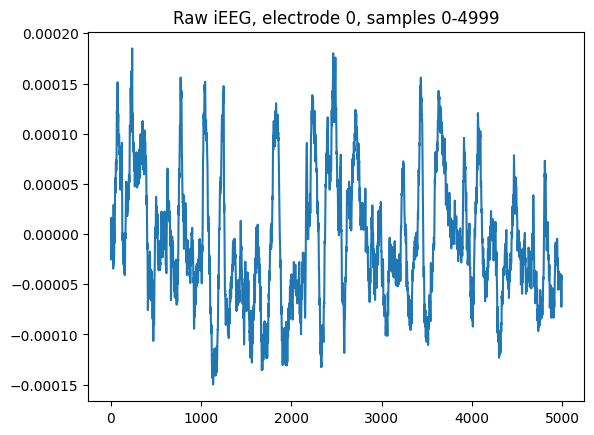

In [10]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [11]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:   17.8s finished


<RawEDF | DA023_SWB.edf, 174 x 960000 (1920.0 s), ~1.24 GB, data loaded>

### Notch filter line noise

In [12]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 174 out of 174 | elapsed:    5.5s finished


<RawEDF | DA023_SWB.edf, 174 x 960000 (1920.0 s), ~1.24 GB, data loaded>

### Photodiode
- examine photodiode 

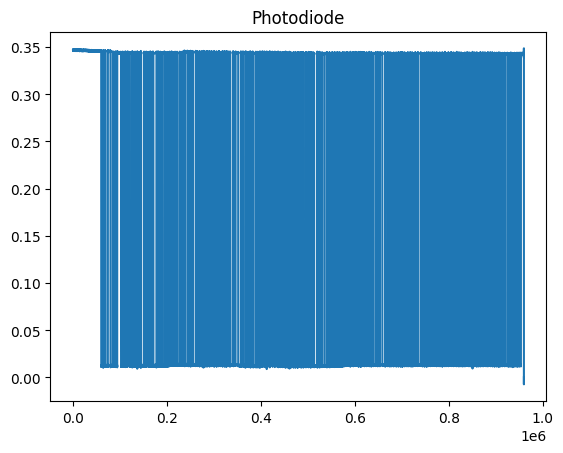

In [13]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("PHOTODIODE")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [14]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='PHOTODIODE', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/photodiode.fif
[done]


In [15]:
mne_data.drop_channels(['PHOTODIODE'])

<RawEDF | DA023_SWB.edf, 173 x 960000 (1920.0 s), ~1.24 GB, data loaded>

### Anatomical Localization

In [16]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | DA023_SWB.edf, 173 x 960000 (1920.0 s), ~1.24 GB, data loaded>

In [17]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination
0,LAC1,A32p_L,-2.948270,35.165349,28.967987,-3.244003,29.783249,18.898609,Gray,Left ACgG anterior cingulate gyrus,Area 33,L ACC,L CG,Left cingulate gyrus G,NaN
1,LAC10,A8dl_L,-17.340510,32.767711,56.937081,-18.622061,32.069451,49.930015,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Unknown,Left superior frontal gyrus 4 D
2,LAC11,A8dl_L,-19.339433,32.368105,60.133549,-20.763493,32.332690,53.556836,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 4 D,NaN
3,LAC12,A8dl_L,-20.938571,31.968499,62.930459,-22.441373,32.456241,56.694248,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 4 D,OOB
4,LAC13,Unknown,-22.537708,31.968499,65.727368,-24.123625,33.000428,59.764154,Unknown,Unknown,Unknown,Unknown,Unknown,Left superior frontal gyrus 4 D,OOB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,LSMG5,A40c_L,-53.720895,-36.763783,29.367546,-54.075538,-48.517991,33.446039,Gray,Left SMG supramarginal gyrus,Area PFm (IPL),L SupraMarginal Gyrus,L IPL,Left supramarginal gyrus 3 B,NaN
146,LSMG6,A40c_L,-57.318955,-36.364177,30.166663,-57.724920,-47.936912,34.325547,Gray,Left SMG supramarginal gyrus,Area PFm (IPL),L SupraMarginal Gyrus,L IPL,Left supramarginal gyrus 3 B,NaN
147,LSMG7,A40c_L,-60.517231,-36.364177,30.965780,-60.975772,-47.795985,35.269393,Gray,Left SMG supramarginal gyrus,Area PFm (IPL),L SupraMarginal Gyrus,L IPL,Left supramarginal gyrus 3 B,NaN
148,LSMG8,A40c_L,-63.715506,-35.964570,31.764897,-64.342587,-47.285110,36.142847,Unknown,Left SMG supramarginal gyrus,Area PFm (IPL),Unknown,L IPL,Left supramarginal gyrus 3 B,OOB


In [18]:
list(elec_locs.label)

['LAC1',
 'LAC10',
 'LAC11',
 'LAC12',
 'LAC13',
 'LAC14',
 'LAC15',
 'LAC16',
 'LAC2',
 'LAC3',
 'LAC4',
 'LAC5',
 'LAC6',
 'LAC7',
 'LAC8',
 'LAC9',
 'LAH1',
 'LAH10',
 'LAH11',
 'LAH12',
 'LAH13',
 'LAH14',
 'LAH15',
 'LAH16',
 'LAH2',
 'LAH3',
 'LAH4',
 'LAH5',
 'LAH6',
 'LAH7',
 'LAH8',
 'LAH9',
 'LAM1',
 'LAM10',
 'LAM11',
 'LAM12',
 'LAM13',
 'LAM14',
 'LAM15',
 'LAM16',
 'LAM2',
 'LAM3',
 'LAM4',
 'LAM5',
 'LAM6',
 'LAM7',
 'LAM8',
 'LAM9',
 'LANG1',
 'LANG10',
 'LANG2',
 'LANG3',
 'LANG4',
 'LANG5',
 'LANG6',
 'LANG7',
 'LANG8',
 'LANG9',
 'LASTG1',
 'LASTG10',
 'LASTG2',
 'LASTG3',
 'LASTG4',
 'LASTG5',
 'LASTG6',
 'LASTG7',
 'LASTG8',
 'LASTG9',
 'LMC1',
 'LMC10',
 'LMC11',
 'LMC12',
 'LMC13',
 'LMC14',
 'LMC15',
 'LMC16',
 'LMC2',
 'LMC3',
 'LMC4',
 'LMC5',
 'LMC6',
 'LMC7',
 'LMC8',
 'LMC9',
 'LMSTG1',
 'LMSTG10',
 'LMSTG2',
 'LMSTG3',
 'LMSTG4',
 'LMSTG5',
 'LMSTG6',
 'LMSTG7',
 'LMSTG8',
 'LMSTG9',
 'LOCC1',
 'LOCC10',
 'LOCC2',
 'LOCC3',
 'LOCC4',
 'LOCC5',
 'LOCC6',
 '

In [19]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['fp1', 'f3', 'c3', 'p3', 'o1', 'f7', 't3', 't5', 't1', 'fp2', 'f4', 'c4', 'p4', 'o2', 'f8', 't4', 't6', 't2', 'fz', 'cz', 'pz', 'audio', 'mic']


In [20]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [21]:
unmatched_seeg #make sure there are no unmatched names


[]

In [22]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [23]:
new_name_dict #make sure this passes the eye test 


{'lam1': 'lam1',
 'lam2': 'lam2',
 'lam3': 'lam3',
 'lam4': 'lam4',
 'lam5': 'lam5',
 'lam6': 'lam6',
 'lam7': 'lam7',
 'lam8': 'lam8',
 'lam9': 'lam9',
 'lam10': 'lam10',
 'lam11': 'lam11',
 'lam12': 'lam12',
 'lam13': 'lam13',
 'lam14': 'lam14',
 'lam15': 'lam15',
 'lam16': 'lam16',
 'lah1': 'lah1',
 'lah2': 'lah2',
 'lah3': 'lah3',
 'lah4': 'lah4',
 'lah5': 'lah5',
 'lah6': 'lah6',
 'lah7': 'lah7',
 'lah8': 'lah8',
 'lah9': 'lah9',
 'lah10': 'lah10',
 'lah11': 'lah11',
 'lah12': 'lah12',
 'lah13': 'lah13',
 'lah14': 'lah14',
 'lah15': 'lah15',
 'lah16': 'lah16',
 'lpmtg1': 'lpmtg1',
 'lpmtg2': 'lpmtg2',
 'lpmtg3': 'lpmtg3',
 'lpmtg4': 'lpmtg4',
 'lpmtg5': 'lpmtg5',
 'lpmtg6': 'lpmtg6',
 'lpmtg7': 'lpmtg7',
 'lpmtg8': 'lpmtg8',
 'lpmtg9': 'lpmtg9',
 'lpmtg10': 'lpmtg10',
 'lastg1': 'lastg1',
 'lastg2': 'lastg2',
 'lastg3': 'lastg3',
 'lastg4': 'lastg4',
 'lastg5': 'lastg5',
 'lastg6': 'lastg6',
 'lastg7': 'lastg7',
 'lastg8': 'lastg8',
 'lastg9': 'lastg9',
 'lastg10': 'lastg10',
 'lm

In [24]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | DA023_SWB.edf, 173 x 960000 (1920.0 s), ~1.24 GB, data loaded>

In [25]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 150 left sEEG and 0 right sEEG electrodes
We have a total of 150 sEEG electrodes


In [26]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | DA023_SWB.edf, 173 x 960000 (1920.0 s), ~1.24 GB, data loaded>

In [27]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | DA023_SWB.edf, 150 x 960000 (1920.0 s), ~1.07 GB, data loaded>

In [28]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | DA023_SWB.edf, 150 x 960000 (1920.0 s), ~1.07 GB, data loaded>

In [29]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [30]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [31]:
probe_ch_counts

{'lac': 16,
 'lah': 16,
 'lam': 16,
 'lang': 10,
 'lastg': 10,
 'lmc': 16,
 'lmstg': 10,
 'locc': 10,
 'lpb': 16,
 'lpmtg': 10,
 'lpstg': 10,
 'lsmg': 10}

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [32]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

In [33]:
#  %matplotlib notebook
# fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/30)


In [34]:
# mne_data.info['bads'] = ['lpmtg3','lpstg9',
#  'lac12',
#  'lac15',
#  'lmc9',
#  'lmc12',
#  'lmc15',
#  'lmc13',
#  'lmc14',
#  'lmc10',
#  'lac2']

## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [32]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [34]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/raw_ieeg.fif...
    Range : 0 ... 959999 =      0.000 ...  1919.998 secs
Ready.
Reading 0 ... 959999  =      0.000 ...  1919.998 secs...


### Bipolar Re-ref

In [35]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=54, n_times=960000
    Range : 0 ... 959999 =      0.000 ...  1919.998 secs
Ready.
Added the following bipolar channels:
lac1-lac2, lac2-lac3, lac3-lac4, lac4-lac5, lac5-lac6, lac6-lac7, lac8-lac9, lac9-lac10, lac10-lac11, lah1-lah2, lah2-lah3, lah5-lah6, lah6-lah7, lah10-lah11, lah11-lah12, lah12-lah13, lah15-lah16, lam1-lam2, lam2-lam3, lam3-lam4, lam4-lam5, lam5-lam6, lam9-lam10, lam10-lam11, lam11-lam12, lam12-lam13, lang1-lang2, lang6-lang7, lang7-lang8, lastg4-lastg5, lastg5-lastg6, lmc2-lmc3, lmc3-lmc4, lmc8-lmc9, lmc9-lmc10, lmc10-lmc11, locc4-locc5, locc5-locc6, locc6-locc7, lpb1-lpb2, lpb6-lpb7, lpb7-lpb8, lpb8-lpb9, lpb9-lpb10, lpb10-lpb11, lpb11-lpb12, lpmtg4-lpmtg5, lpmtg5-lpmtg6, lpstg7-lpstg8, lsmg1-lsmg2, lsmg2-lsmg3, lsmg4-lsmg5, lsmg5-lsmg6, lsmg6-lsmg7


In [36]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 54 x 960000 (1920.0 s), ~395.6 MB, data loaded>

In [37]:
mne_data_bp_reref.ch_names

['lac1-lac2',
 'lac2-lac3',
 'lac3-lac4',
 'lac4-lac5',
 'lac5-lac6',
 'lac6-lac7',
 'lac8-lac9',
 'lac9-lac10',
 'lac10-lac11',
 'lah1-lah2',
 'lah2-lah3',
 'lah5-lah6',
 'lah6-lah7',
 'lah10-lah11',
 'lah11-lah12',
 'lah12-lah13',
 'lah15-lah16',
 'lam1-lam2',
 'lam2-lam3',
 'lam3-lam4',
 'lam4-lam5',
 'lam5-lam6',
 'lam9-lam10',
 'lam10-lam11',
 'lam11-lam12',
 'lam12-lam13',
 'lang1-lang2',
 'lang6-lang7',
 'lang7-lang8',
 'lastg4-lastg5',
 'lastg5-lastg6',
 'lmc2-lmc3',
 'lmc3-lmc4',
 'lmc8-lmc9',
 'lmc9-lmc10',
 'lmc10-lmc11',
 'locc4-locc5',
 'locc5-locc6',
 'locc6-locc7',
 'lpb1-lpb2',
 'lpb6-lpb7',
 'lpb7-lpb8',
 'lpb8-lpb9',
 'lpb9-lpb10',
 'lpb10-lpb11',
 'lpb11-lpb12',
 'lpmtg4-lpmtg5',
 'lpmtg5-lpmtg6',
 'lpstg7-lpstg8',
 'lsmg1-lsmg2',
 'lsmg2-lsmg3',
 'lsmg4-lsmg5',
 'lsmg5-lsmg6',
 'lsmg6-lsmg7']

# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


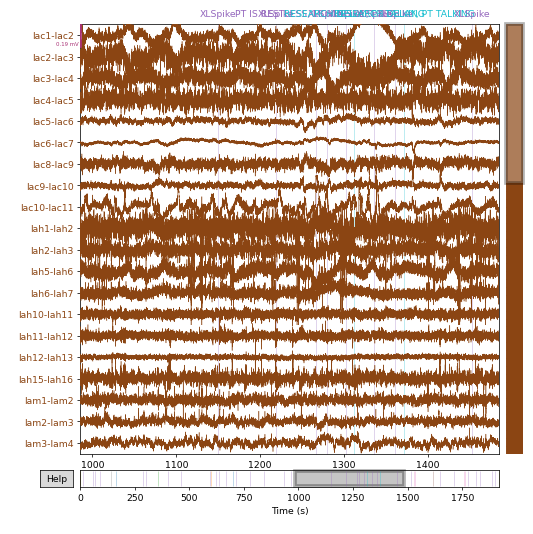

In [38]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=20, scalings=mne_data_bp_reref._data.max()/50)


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


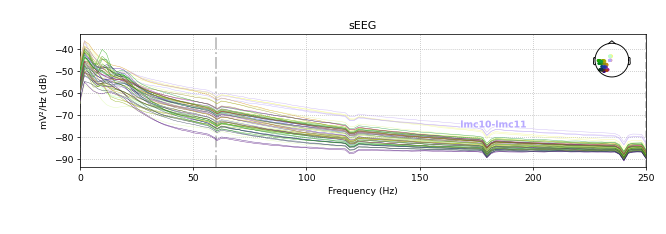

<IPython.core.display.Javascript object>


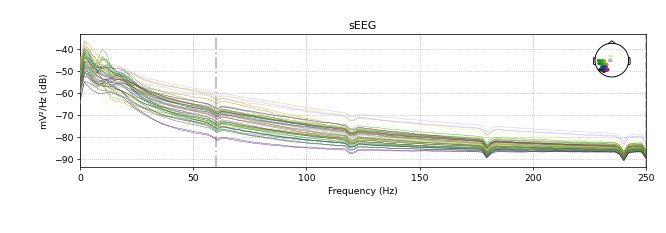

In [39]:
mne_data_bp_reref.compute_psd().plot()

In [40]:
print(mne_data_bp_reref.info['bads'],date)

[] 05212024


## Save Reref Data

In [41]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/bp_ref_ieeg.fif
[done]


In [42]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [43]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,68.0,gain,226.667426,226.671416,228.779282,230.796562,2.107865,0.3,0.00,...,1.08,0.78,0.00,0.0,1.08,0.78,0.00,0.30,0.540,0.00
1,2,85.0,gain,234.872443,234.893133,239.441643,241.458694,4.548509,0.5,0.00,...,1.24,0.74,0.00,0.0,1.24,0.74,0.00,0.50,0.620,0.00
2,3,76.0,gain,246.187263,246.203895,249.303626,251.320210,3.099731,0.4,0.00,...,-1.12,-0.40,-1.12,-0.4,0.00,0.00,1.12,0.40,0.000,-0.56
3,4,56.0,gain,264.647861,264.666498,269.161376,271.178256,4.494878,0.2,0.00,...,-0.56,-0.20,-0.56,-0.2,0.00,0.00,0.56,0.20,0.000,-0.28
4,5,31.0,mix,276.618198,276.635340,280.822825,280.831447,4.187485,0.0,-1.50,...,1.50,1.50,0.00,0.0,1.50,1.50,-1.50,-1.50,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,74.0,gain,1887.903226,1887.904228,1889.144100,1891.160797,1.239872,0.4,0.00,...,0.89,0.49,0.00,0.0,0.89,0.49,0.00,0.40,0.445,0.00
146,147,88.0,gain,1895.726328,1895.727413,1896.891048,1898.907664,1.163636,0.5,0.00,...,1.80,1.30,0.00,0.0,1.80,1.30,0.00,0.50,0.900,0.00
147,148,144.0,loss,1905.271849,1905.272834,1907.119859,1907.126331,1.847025,-0.6,-1.33,...,0.73,0.73,0.00,0.0,0.73,0.73,-1.33,-1.33,0.000,0.00
148,149,87.0,gain,1914.370711,1914.383463,1915.948606,1917.965770,1.565143,0.5,0.00,...,-1.58,-0.50,-1.58,-0.5,0.00,0.00,1.58,0.50,0.000,-0.79


In [44]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/photodiode.fif...
Isotrak not found
    Range : 0 ... 959999 =      0.000 ...  1919.998 secs
Ready.
Reading 0 ... 959999  =      0.000 ...  1919.998 secs...


In [45]:
photodiode_data

<Raw | photodiode.fif, 1 x 960000 (1920.0 s), ~7.3 MB, data loaded>

<IPython.core.display.Javascript object>


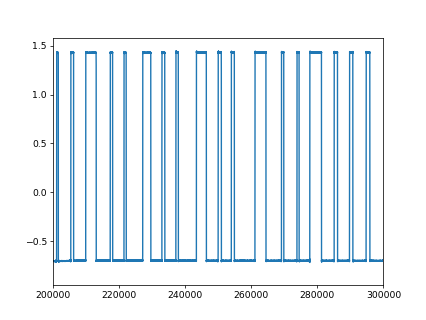

In [47]:
plt.plot(zscore(photodiode_data._data[0,:]))
plt.xlim([200000,300000])
plt.show()


In [48]:
temp_diode = photodiode_data.copy()
temp_diode._data = np.negative(temp_diode._data)

<IPython.core.display.Javascript object>


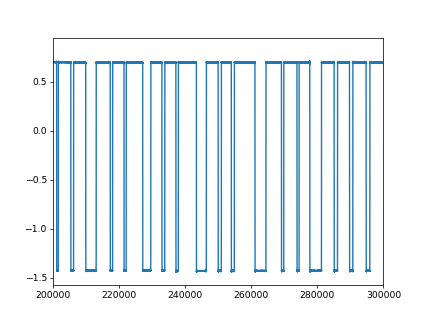

In [49]:
plt.plot(zscore(temp_diode._data[0,:]))
plt.xlim([200000,300000])
plt.show()


In [50]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.5


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 120 of 157 pulses


In [51]:
print(slope, offset,smoothSize,windSize,height)

0.9999974476722991 -22.281898564340565 11 15 0.5


In [52]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

150

In [53]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

<IPython.core.display.Javascript object>


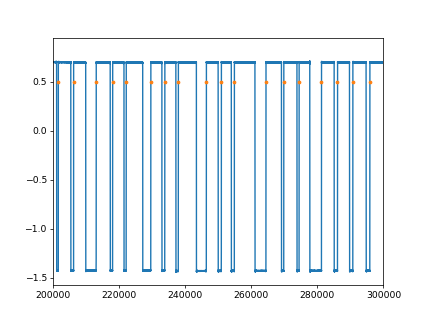

In [56]:
plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')

plt.xlim([200000,300000])
# plt.xlim([500000,700000])
plt.show()

# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [57]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,68.0,gain,226.667426,226.671416,228.779282,230.796562,2.107865,0.3,0.00,...,1.08,0.78,0.00,0.0,1.08,0.78,0.00,0.30,0.540,0.00
1,2,85.0,gain,234.872443,234.893133,239.441643,241.458694,4.548509,0.5,0.00,...,1.24,0.74,0.00,0.0,1.24,0.74,0.00,0.50,0.620,0.00
2,3,76.0,gain,246.187263,246.203895,249.303626,251.320210,3.099731,0.4,0.00,...,-1.12,-0.40,-1.12,-0.4,0.00,0.00,1.12,0.40,0.000,-0.56
3,4,56.0,gain,264.647861,264.666498,269.161376,271.178256,4.494878,0.2,0.00,...,-0.56,-0.20,-0.56,-0.2,0.00,0.00,0.56,0.20,0.000,-0.28
4,5,31.0,mix,276.618198,276.635340,280.822825,280.831447,4.187485,0.0,-1.50,...,1.50,1.50,0.00,0.0,1.50,1.50,-1.50,-1.50,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,74.0,gain,1887.903226,1887.904228,1889.144100,1891.160797,1.239872,0.4,0.00,...,0.89,0.49,0.00,0.0,0.89,0.49,0.00,0.40,0.445,0.00
146,147,88.0,gain,1895.726328,1895.727413,1896.891048,1898.907664,1.163636,0.5,0.00,...,1.80,1.30,0.00,0.0,1.80,1.30,0.00,0.50,0.900,0.00
147,148,144.0,loss,1905.271849,1905.272834,1907.119859,1907.126331,1.847025,-0.6,-1.33,...,0.73,0.73,0.00,0.0,0.73,0.73,-1.33,-1.33,0.000,0.00
148,149,87.0,gain,1914.370711,1914.383463,1915.948606,1917.965770,1.565143,0.5,0.00,...,-1.58,-0.50,-1.58,-0.5,0.00,0.00,1.58,0.50,0.000,-0.79


In [58]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('gamble', 228.7792818823309, 230.79656154394613),
 ('gamble', 239.44164274204013, 241.458693710284),
 ('gamble', 249.3036262918185, 251.32020997464952),
 ('gamble', 269.16137628354136, 271.17825624375564),
 ('safe', 280.8228251004284, 280.8314471819004),
 ('safe', 290.3850530790487, 290.39376800320315),
 ('safe', 305.47837396964223, 305.4877780459137),
 ('gamble', 319.1050071219215, 321.122690580939),
 ('safe', 328.3174489288449, 328.32564878091034),
 ('safe', 345.46014983853183, 345.469410896113),
 ('gamble', 356.9879072406029, 359.005739862313),
 ('gamble', 371.91490729214456, 373.9328221752021),
 ('gamble', 386.90817039499416, 388.9244328831028),
 ('gamble', 395.38764379949134, 397.4044623196951),
 ('gamble', 405.5825403874205, 407.5997456383566),
 ('safe', 418.7765321005281, 418.78479236860494),
 ('gamble', 427.3898317465309, 429.4078766776111),
 ('safe', 436.40233103399805, 436.4108213607806),
 ('gamble', 451.26189930869714, 453.2790820316304),
 ('safe', 459.6085172238536, 459.6

In [59]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0       230.779282
1       241.441643
2       251.303626
3       271.161376
4       282.822825
          ...     
145    1891.144100
146    1898.891048
147    1909.119859
148    1917.948606
149    1926.411432
Name: CpeOnset, Length: 150, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [60]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [61]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [62]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [63]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/bp_ref_ieeg.fif...
    Range : 0 ... 959999 =      0.000 ...  1919.998 secs
Ready.
Reading 0 ... 959999  =      0.000 ...  1919.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    5.3s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/bp_ref_ieeg.fif...
    Range : 0 ... 959999 =      0.000 ...  1919.998 secs
Ready.
Reading 0 ... 959999  =      0.000 ...  1919.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    5.2s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA023/bp_ref_ieeg.fif...
    Range : 0 ... 959999 =      0.000 ...  1919.998 secs
Ready.
Reading 0 ... 959999  =      0.000 ...  1919.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    5.3s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 2501 original time points ...
0 bad epochs dropped


In [64]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~92.9 MB, data loaded,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~77.4 MB, data loaded,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~154.7 MB, data loaded,
  'CpeOnset': 150>}

In [65]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [66]:
behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
                'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
                'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
                'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [67]:
for event in evs.keys():

    event_metadata = pd.DataFrame(columns=behav_params)
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Adding metadata with 19 columns
Adding metadata with 19 columns
Adding metadata with 19 columns


### Save raw epoched data 

In [68]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


In [69]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~92.9 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~77.4 MB, data loaded, with metadata,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~154.7 MB, data loaded, with metadata,
  'CpeOnset': 150>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [70]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [71]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [72]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   26.6s finished


Adding metadata with 19 columns


In [73]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 54, ~928.9 MB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [74]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   18.1s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
Not setting metadata
Adding metadata with 19 columns
Compute baselined TFR for epoch:  CpeOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   38.8s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
Not setting metadata
Adding metadata with 19 columns


In [75]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 54, ~465.5 MB>,
 'CpeOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 54, ~2.72 GB>}

In [76]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 54, ~465.5 MB>

In [77]:
power_epochs['CpeOnset']

<EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 54, ~2.72 GB>

# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [78]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/single_elec_tfrs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


05212024 -22.281898564340565


In [79]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    

Plot TFR for epoch:  DecisionOnset
Plot TFR for epoch:  CpeOnset
